# Tagoloan Data Mining Notebook

<div>
    <img src='https://scontent.fcgm1-1.fna.fbcdn.net/v/t31.18172-8/178400_310845702362771_797955880_o.jpg?_nc_cat=102&ccb=1-7&_nc_sid=c2f564&_nc_ohc=JBsBSr1CBR0AX8Mdzl3&_nc_ht=scontent.fcgm1-1.fna&oh=00_AfD4DfDHmG-MMcEv3klL03DCKWdXd5qoFxgMV6pa8quDVA&oe=65D98E59' width='500px' style='display: block; margin-left: auto; margin-right: auto; width: 50%;'/>
</div>

This notebook processes the cleaned data from the data cleaning notebook. Processes of this notebook includes the following:
1. Removes hour and minute from the timestamp.
2. Clean duplicated data by keeping the first duplicated variable.
3. Ammend missing Water Level Data by Interpolation.
4. File integrity checker

### Authors
- Engr. Gifrey John M. Sulay

### Checked by:
- Dr. Anabel A. Abuzo
- Engr. Augustine Ave Padagunan

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from pathlib import Path
import os
from IPython.display import display

__author__ = "Gifrey John M. Sulay"
__copyright__ = "Xavier University - Engineering Resource Center"

MAX_SENSOR_VAL = 819.2
VAL_THRESHOLD = 305*0.75    #Based from Arizona University https://wmo.asu.edu/content/world-greatest-sixty-minute-one-hour-rainfall
                            #Added a factor in case of jump

In [2]:
import datetime
from dateutil.relativedelta import relativedelta

def set_time_range():
    run = True
    while run:
        try:
            input_start_date = str(input("Please input Start Date (Format=Month,Date,Year): "))
            start_date_datetime = pd.to_datetime(input_start_date,format="%m,%d,%Y")

            input_end_date = str(input("Please input End Date (Format=Month,Date,Year): "))
            end_date_datetime = pd.to_datetime(input_end_date,format="%m,%d,%Y")

            print((f"Date start is {start_date_datetime} and End Date is {end_date_datetime + datetime.timedelta(days = 1)}"))
            date_confirm = input("Type y if the input is correct or n to try again: ")
            if date_confirm == "y":
                start_date = start_date_datetime
                end_date = end_date_datetime + datetime.timedelta(days = 1)
                run = False
            elif date_confirm == "n":
                continue
            else:
                raise ValueError
                
        except Exception as e:
            print(e)
    return start_date, end_date

is_range = input("Do you wish to select a range? (y for yes, n for no and select entire available data)")

run=True
while run:
    try:
        if is_range == "y" or "Y":
            start_date, end_date = set_time_range()
        elif is_range == "n" or "N":
            start_date, end_date = (None, None)
        else:
            raise ValueError('Not valid argument. Please try again')
        run = False
    except Exception as e:
        print(e)


Date start is 2021-12-01 00:00:00 and End Date is 2021-12-16 00:00:00


In [3]:
tag_path = Path("Edited_Data/Tagoloan/tag.csv")
rg0_path = Path("Edited_Data/Tagoloan/rg0.csv")
rg1_path = Path("Edited_Data/Tagoloan/rg1.csv")

tag = pd.read_csv(tag_path)[['Timestamp', 'Sensor Value']]
rg_0 = pd.read_csv(rg0_path)[['Timestamp', 'Sensor Value']]
rg_1 = pd.read_csv(rg1_path)[['Timestamp', 'Sensor Value']]

display('Tagoloan Water Table',tag.head(),tag.tail())
display('Rain Gauge 0 Data',rg_0.head(),rg_0.tail())
display('Rain Gauge 1 Data',rg_1.head(),rg_1.tail())

'Tagoloan Water Table'

,Timestamp,Sensor Value
0,12/2/2019 12:47:00 AM,1.654815
1,12/2/2019 1:47:00 AM,1.678690
2,12/2/2019 2:47:00 AM,1.654815
3,12/2/2019 3:47:00 AM,1.654815
4,12/2/2019 4:47:00 AM,1.583190


,Timestamp,Sensor Value
18563,1/1/2022 10:47:00 AM,1.583190
18564,1/1/2022 11:47:00 AM,1.559315
18565,1/1/2022 12:47:00 PM,1.010190
18566,1/1/2022 1:47:00 PM,1.439940
18567,1/1/2022 2:47:00 PM,0.962440


'Rain Gauge 0 Data'

,Timestamp,Sensor Value
0,1/27/2020 12:47:00 AM,207.2
1,1/27/2020 1:47:00 AM,207.2
2,1/27/2020 2:47:00 AM,207.2
3,1/27/2020 3:47:00 AM,207.2
4,1/27/2020 4:47:00 AM,207.2


,Timestamp,Sensor Value
15169,7/31/2021 7:47:00 PM,252.8
15170,7/31/2021 8:47:00 PM,252.8
15171,7/31/2021 9:47:00 PM,252.8
15172,7/31/2021 10:47:00 PM,252.8
15173,7/31/2021 11:47:00 PM,252.8


'Rain Gauge 1 Data'

,Timestamp,Sensor Value
0,10/1/2020 12:59:59 AM,0.112
1,10/1/2020 1:59:59 AM,0.112
2,10/1/2020 2:59:59 AM,0.112
3,10/1/2020 3:59:59 AM,0.112
4,10/1/2020 4:59:59 AM,0.112


,Timestamp,Sensor Value
22057,5/19/2022 7:59:59 PM,0.0
22058,5/19/2022 8:59:59 PM,0.0
22059,5/19/2022 9:59:59 PM,0.0
22060,5/19/2022 10:59:59 PM,0.0
22061,5/19/2022 11:59:59 PM,0.0


### Checking For Duplicates

In [4]:
#Delete duplicates
tag_1 = tag.drop_duplicates(subset="Timestamp", keep='first')
rg_0_1 = rg_0.drop_duplicates(subset="Timestamp", keep='first')
rg_1_1 = rg_1.drop_duplicates(subset="Timestamp",keep='first')

cag_dropped=len(tag)-len(tag_1)
rg_0_dropped=len(rg_0)-len(rg_0_1)
rg_1_dropped=len(rg_1)-len(rg_1_1)

print(f"No of cells dropped from water level table is {cag_dropped} cells")
print(f"No of cells dropped from rain gauge 0 table is {rg_0_dropped} cells")
print(f"No of cells dropped from rain gauge 1 table is {rg_1_dropped} cells")

tag = tag_1
rg_0 = rg_0_1
rg_1 = rg_1_1

display(tag, rg_0, rg_1)

No of cells dropped from water level table is 483 cells
No of cells dropped from rain gauge 0 table is 173 cells
No of cells dropped from rain gauge 1 table is 2389 cells


,Timestamp,Sensor Value
0,12/2/2019 12:47:00 AM,1.654815
1,12/2/2019 1:47:00 AM,1.678690
2,12/2/2019 2:47:00 AM,1.654815
3,12/2/2019 3:47:00 AM,1.654815
4,12/2/2019 4:47:00 AM,1.583190
...,...,...
18563,1/1/2022 10:47:00 AM,1.583190
18564,1/1/2022 11:47:00 AM,1.559315
18565,1/1/2022 12:47:00 PM,1.010190
18566,1/1/2022 1:47:00 PM,1.439940


,Timestamp,Sensor Value
0,1/27/2020 12:47:00 AM,207.2
1,1/27/2020 1:47:00 AM,207.2
2,1/27/2020 2:47:00 AM,207.2
3,1/27/2020 3:47:00 AM,207.2
4,1/27/2020 4:47:00 AM,207.2
...,...,...
15169,7/31/2021 7:47:00 PM,252.8
15170,7/31/2021 8:47:00 PM,252.8
15171,7/31/2021 9:47:00 PM,252.8
15172,7/31/2021 10:47:00 PM,252.8


,Timestamp,Sensor Value
0,10/1/2020 12:59:59 AM,0.112
1,10/1/2020 1:59:59 AM,0.112
2,10/1/2020 2:59:59 AM,0.112
3,10/1/2020 3:59:59 AM,0.112
4,10/1/2020 4:59:59 AM,0.112
...,...,...
22057,5/19/2022 7:59:59 PM,0.000
22058,5/19/2022 8:59:59 PM,0.000
22059,5/19/2022 9:59:59 PM,0.000
22060,5/19/2022 10:59:59 PM,0.000


### Time format

We have the timestamp data but it is ***unreadable*** for indexing as these are just text strings. Thus, we convert the string Timestamp data into a readable format for the pandas module used in this noetbook for data cleaning.

In [5]:
def column_apply(df,column, function):
    df[column] = df[column].apply(function)

def map_apply(df,function):
    df =  df.applymap(function)

In [6]:
import datetime

column_apply(tag,'Timestamp', lambda x: pd.to_datetime(x).replace(second = 0, minute=0))
column_apply(rg_0,'Timestamp', lambda x: pd.to_datetime(x).replace(second = 0, minute=0))
column_apply(rg_1,'Timestamp', lambda x: pd.to_datetime(x).replace(second = 0, minute=0))

### Transforms the data into proper format

The data as it stands now is by ***30-minute increments***. We want the data to be transformed into an hourly format. Thus, we get the mean average of all the data points in an hourly timeframe.

In [7]:
# rg_0 = rg_0.groupby(by='Timestamp').mean().reset_index()
# tag = tag.groupby(by='Timestamp').mean().reset_index()

tag=tag.rename(columns={"Sensor Value":"Water Level"})
rg_0=rg_0.rename(columns={"Sensor Value":"Rain Gauge 0"})
rg_1=rg_1.rename(columns={"Sensor Value":"Rain Gauge 1"})

### Checking for Missing Data

Create a new dataframe with correct timestamp progression and merge the water level dataframe and rain gauge dataframe to the correct timestamp progression as the base.

The correct timestamp progression will start at the earliest date from either the rain gauge and water level tables and will end at their latest.

**Note:** This function, as of most the entire notebook, is borrowed from the ***Cagayan Processing*** jupyter notebook. Since the function only uses 2 variable, we assume that RG0 and RG1 have the same length given that these files come from the same sensor.

In [8]:
def make_base_time(cag,rg):
    rg_start_date = rg.iloc[0,0]
    rg_end_date = rg.iloc[-1,0]
    cag_start_date = cag.iloc[0,0]
    cag_end_date = cag.iloc[-1,0]


    if rg_start_date > cag_start_date:
        start_date = cag_start_date
    else:
        start_date = rg_start_date

    if rg_end_date < cag_end_date:
        end_date = cag_end_date
    else:
        end_date = rg_end_date

    base_time = pd.DataFrame({'Timestamp':pd.date_range(start=start_date, end=end_date, freq="H")})
    return base_time

if start_date != None:
    base_time = pd.DataFrame({'Timestamp':pd.date_range(start=start_date, end=end_date, freq="H")})
else:
    base_time = make_base_time(tag,rg_0)

Now let's merge all the data

In [9]:
cag = pd.merge(base_time, tag, how='left', on='Timestamp')
main_df = pd.merge(cag,rg_0,how='left', on='Timestamp')
main_df = pd.merge(main_df,rg_1,how='left', on='Timestamp')

Let's see the missing Data

In [10]:
missing_water = main_df.loc[main_df['Water Level'].isna()]
missing_rg_0 = main_df.loc[main_df['Rain Gauge 0'].isna()]
missing_rg_1 = main_df.loc[main_df['Rain Gauge 1'].isna()]

display(missing_water, missing_rg_0, missing_rg_1)

,Timestamp,Water Level,Rain Gauge 0,Rain Gauge 1
304,2021-12-13 16:00:00,NaN,NaN,0.0
306,2021-12-13 18:00:00,NaN,NaN,0.0


,Timestamp,Water Level,Rain Gauge 0,Rain Gauge 1
304,2021-12-13 16:00:00,NaN,NaN,0.0
306,2021-12-13 18:00:00,NaN,NaN,0.0


,Timestamp,Water Level,Rain Gauge 0,Rain Gauge 1


### Hour and Rain Gauge Difference Data
Create a new column to input the hour the data was recorded.

We also create a new column for the Rain Gauge difference by subtracting the current value to its preceeding value and where all negative values are replaced with a 0.

In [11]:
main_df['Hour'] = main_df['Timestamp'].apply(lambda x: pd.to_datetime(x).strftime('%H'))

#Rearranges the datafrom to place the Hour data as the first column
main_df = main_df[['Hour']+main_df.columns.values[:-1].tolist()]

Interpolate the missing Rain Gauge Data

In [12]:
main_df['Rain Gauge 1'] = main_df['Rain Gauge 1'].astype('float64').interpolate()
main_df['Rain Gauge 0'] = main_df['Rain Gauge 0'].astype('float64').interpolate()

In [13]:
def rg_diff(lst):
    new_list = [0]
    count = 1
    for value in lst[1:]:
        if value-lst[count-1] > 0:
            value-=lst[count-1]
            new_list.append(value)
        else:
            new_list.append(0)
        count += 1
    return new_list



main_df['RG0_Diff'] = rg_diff(main_df.loc[:,'Rain Gauge 0'])
main_df['RG1_Diff'] = main_df.loc[:,'Rain Gauge 1']     #RG1 Already in difference

main_df

,Hour,Timestamp,Water Level,Rain Gauge 0,Rain Gauge 1,RG0_Diff,RG1_Diff
0,00,2021-12-01 00:00:00,0.413315,344.0,0.088,0.0,0.088
1,01,2021-12-01 01:00:00,0.914690,344.0,0.088,0.0,0.088
2,02,2021-12-01 02:00:00,0.484940,344.0,0.088,0.0,0.088
3,03,2021-12-01 03:00:00,0.986315,344.0,0.088,0.0,0.088
4,04,2021-12-01 04:00:00,0.580440,344.0,0.088,0.0,0.088
...,...,...,...,...,...,...,...
356,20,2021-12-15 20:00:00,0.938565,410.2,0.344,4.4,0.344
357,21,2021-12-15 21:00:00,0.866940,411.6,0.400,1.4,0.400
358,22,2021-12-15 22:00:00,0.986315,412.2,0.424,0.6,0.424
359,23,2021-12-15 23:00:00,0.437190,414.4,0.512,2.2,0.512


### Check for Erroneous Water Level Data

As there may be instrumental errors from the sensors used, we check if there are any errors by removing the cell with a difference greater than 0.5 from its previous cell and interpolating it in place. 

In [14]:
def clean_water_level(df, column, diff_limit = 0.5):
    corrected_df = df.copy()
    water_level = corrected_df[column]
    #diff limit determines whether the difference is erroneous if difference is more than diff limit then data is erroneous
    is_erroneous=[0]
    count = 1
    
    for i in water_level[1:]:
        val = i-water_level[count - 1]
        val = abs(val)
        if val >= diff_limit:
            is_erroneous.append(1)
        else:
            is_erroneous.append(0)
        count += 1
    corrected_df['err_check']=is_erroneous
    corrected_df.loc[corrected_df['err_check']==1, column] = np.nan
    
    edited_water_level=corrected_df.loc[:, column]
    final_water_level=edited_water_level.astype('float64').interpolate()
    corrected_df=corrected_df.drop(columns=[column,'err_check'])
    corrected_df[column]=final_water_level
    return corrected_df

corrected_main_df = clean_water_level(main_df, 'Water Level', diff_limit=0.5)

display('Raw Water Table',main_df,'Corrected Water Table',corrected_main_df)

'Raw Water Table'

,Hour,Timestamp,Water Level,Rain Gauge 0,Rain Gauge 1,RG0_Diff,RG1_Diff
0,00,2021-12-01 00:00:00,0.413315,344.0,0.088,0.0,0.088
1,01,2021-12-01 01:00:00,0.914690,344.0,0.088,0.0,0.088
2,02,2021-12-01 02:00:00,0.484940,344.0,0.088,0.0,0.088
3,03,2021-12-01 03:00:00,0.986315,344.0,0.088,0.0,0.088
4,04,2021-12-01 04:00:00,0.580440,344.0,0.088,0.0,0.088
...,...,...,...,...,...,...,...
356,20,2021-12-15 20:00:00,0.938565,410.2,0.344,4.4,0.344
357,21,2021-12-15 21:00:00,0.866940,411.6,0.400,1.4,0.400
358,22,2021-12-15 22:00:00,0.986315,412.2,0.424,0.6,0.424
359,23,2021-12-15 23:00:00,0.437190,414.4,0.512,2.2,0.512


'Corrected Water Table'

,Hour,Timestamp,Rain Gauge 0,Rain Gauge 1,RG0_Diff,RG1_Diff,Water Level
0,00,2021-12-01 00:00:00,344.0,0.088,0.0,0.088,0.413315
1,01,2021-12-01 01:00:00,344.0,0.088,0.0,0.088,0.449128
2,02,2021-12-01 02:00:00,344.0,0.088,0.0,0.088,0.484940
3,03,2021-12-01 03:00:00,344.0,0.088,0.0,0.088,0.532690
4,04,2021-12-01 04:00:00,344.0,0.088,0.0,0.088,0.580440
...,...,...,...,...,...,...,...
356,20,2021-12-15 20:00:00,410.2,0.344,4.4,0.344,0.938565
357,21,2021-12-15 21:00:00,411.6,0.400,1.4,0.400,0.866940
358,22,2021-12-15 22:00:00,412.2,0.424,0.6,0.424,0.986315
359,23,2021-12-15 23:00:00,414.4,0.512,2.2,0.512,0.699815


### Plot the Water Table and Rain Gauge Data

We plot the water table against its corrected water level data from the previous cell and we plot the rain gauge data against its difference.

Shown below is the ***Water Level*** progression for the month

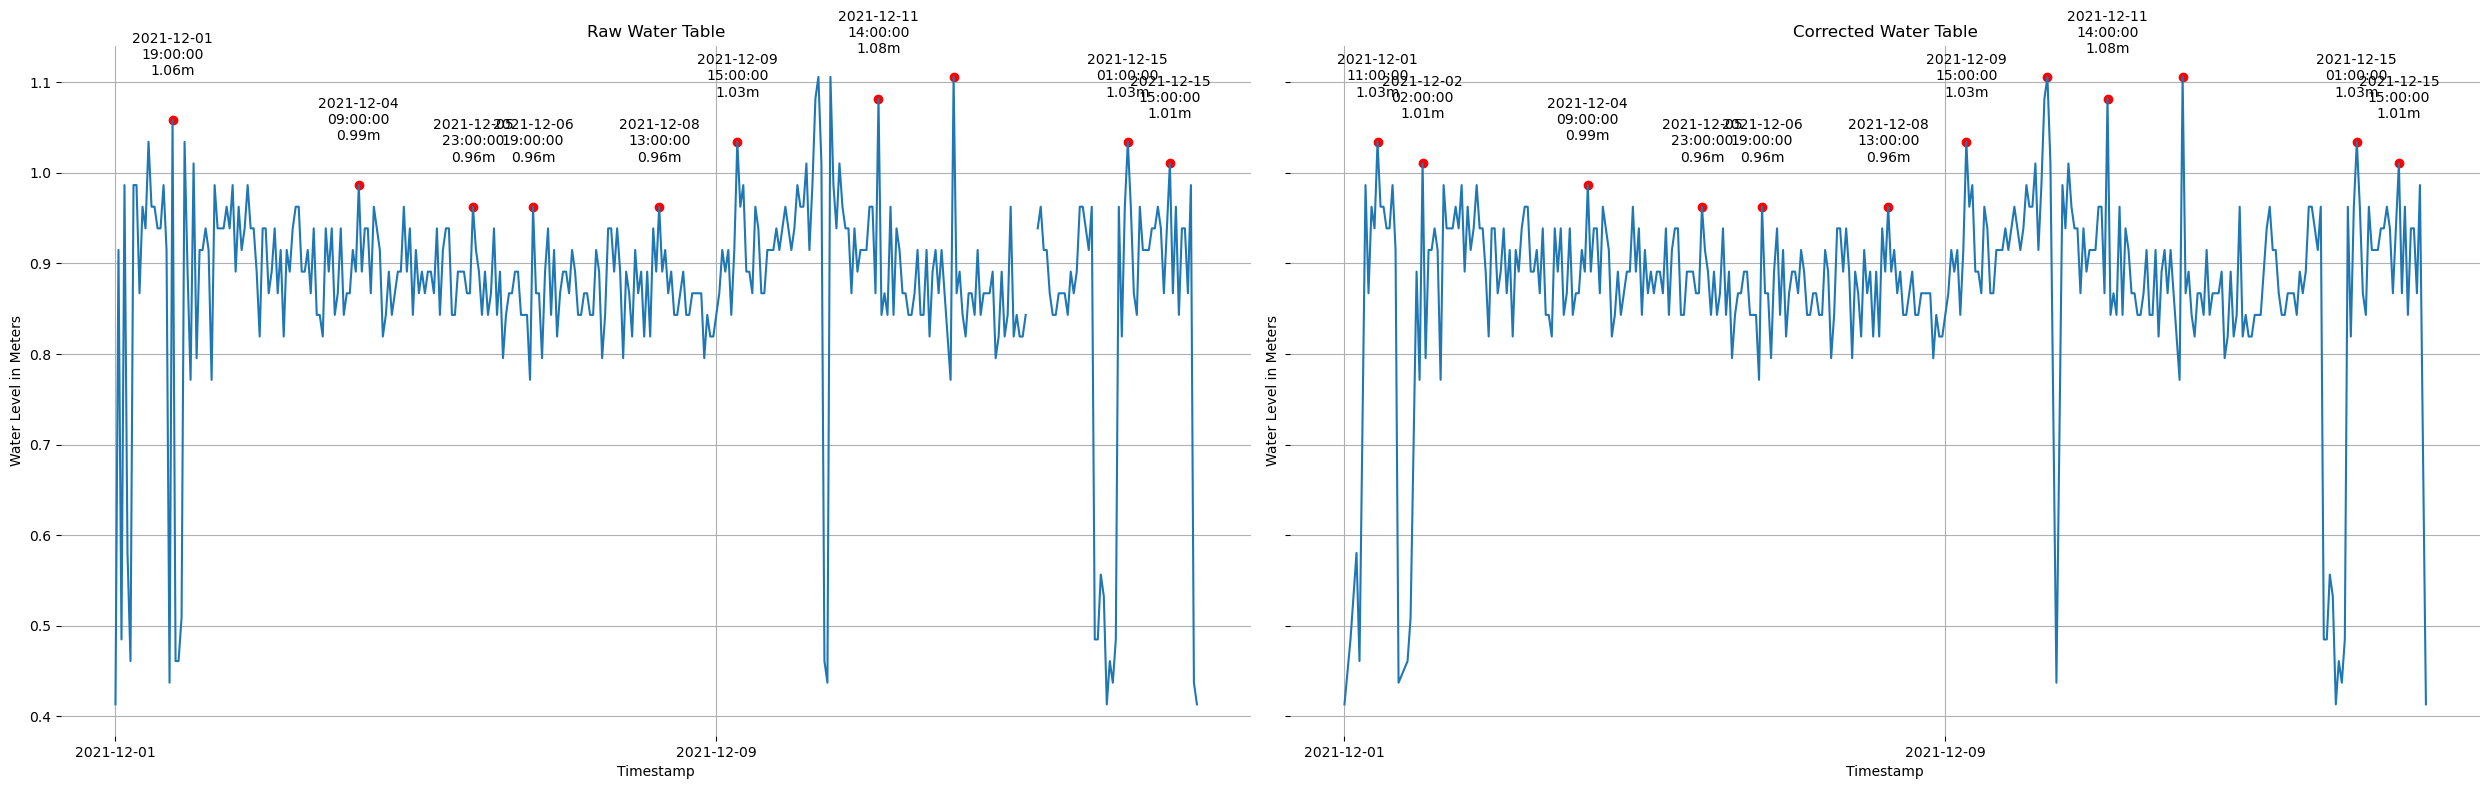

In [15]:
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

fig,ax = plt.subplots(1,2, figsize=(25,8), sharey=True)

#Water Level Plot
water_level = main_df['Water Level'].to_numpy()
ax[0].plot(main_df['Timestamp'], water_level)
ax[0].set_title('Raw Water Table')
water_level_max_index = argrelextrema(water_level, np.greater , order = 10)
ax[0].scatter(main_df.loc[water_level_max_index[0], 'Timestamp'], water_level[water_level_max_index[0]], color='r')

for index in water_level_max_index[0]:
    timestamp=str(main_df.loc[index, 'Timestamp'])
    ax[0].annotate("{}\n{}\n{:.2f}m".format(timestamp.split()[0],timestamp.split()[1], water_level[index]),
    (main_df.loc[index, 'Timestamp'], water_level[index]+0.05),
    ha='center')

#Corrected Water Level Plot
corrected_water_level = corrected_main_df['Water Level'].to_numpy()
ax[1].plot(main_df['Timestamp'], corrected_water_level)
ax[1].set_title('Corrected Water Table')
corrected_water_level_max_index = argrelextrema(corrected_water_level, np.greater , order = 10)
ax[1].scatter(main_df.loc[corrected_water_level_max_index[0], 'Timestamp'], corrected_water_level[corrected_water_level_max_index[0]], color='r')

for index in corrected_water_level_max_index[0]:
    timestamp=str(main_df.loc[index, 'Timestamp'])
    ax[1].annotate("{}\n{}\n{:.2f}m".format(timestamp.split()[0],timestamp.split()[1],corrected_water_level[index]),
    (main_df.loc[index, 'Timestamp'], corrected_water_level[index] + 0.05,),
    ha='center')

#Plot Settings
label = np.arange(0,len(main_df['Timestamp']),1) % 200 == 0
for x in ax:
    x.set_xticks(main_df["Timestamp"].loc[label])
    x.set_xlabel("Timestamp")
    x.set_ylabel("Water Level in Meters")
    x.grid(visible=True)

    x.spines['top'].set_visible(False)
    x.spines['right'].set_visible(False)
    x.spines['bottom'].set_visible(False)
    x.spines['left'].set_visible(False)
fig.tight_layout()

water_fig = fig
plt.show()

Shown below is the ***Rain Gauge 0*** progression for the month

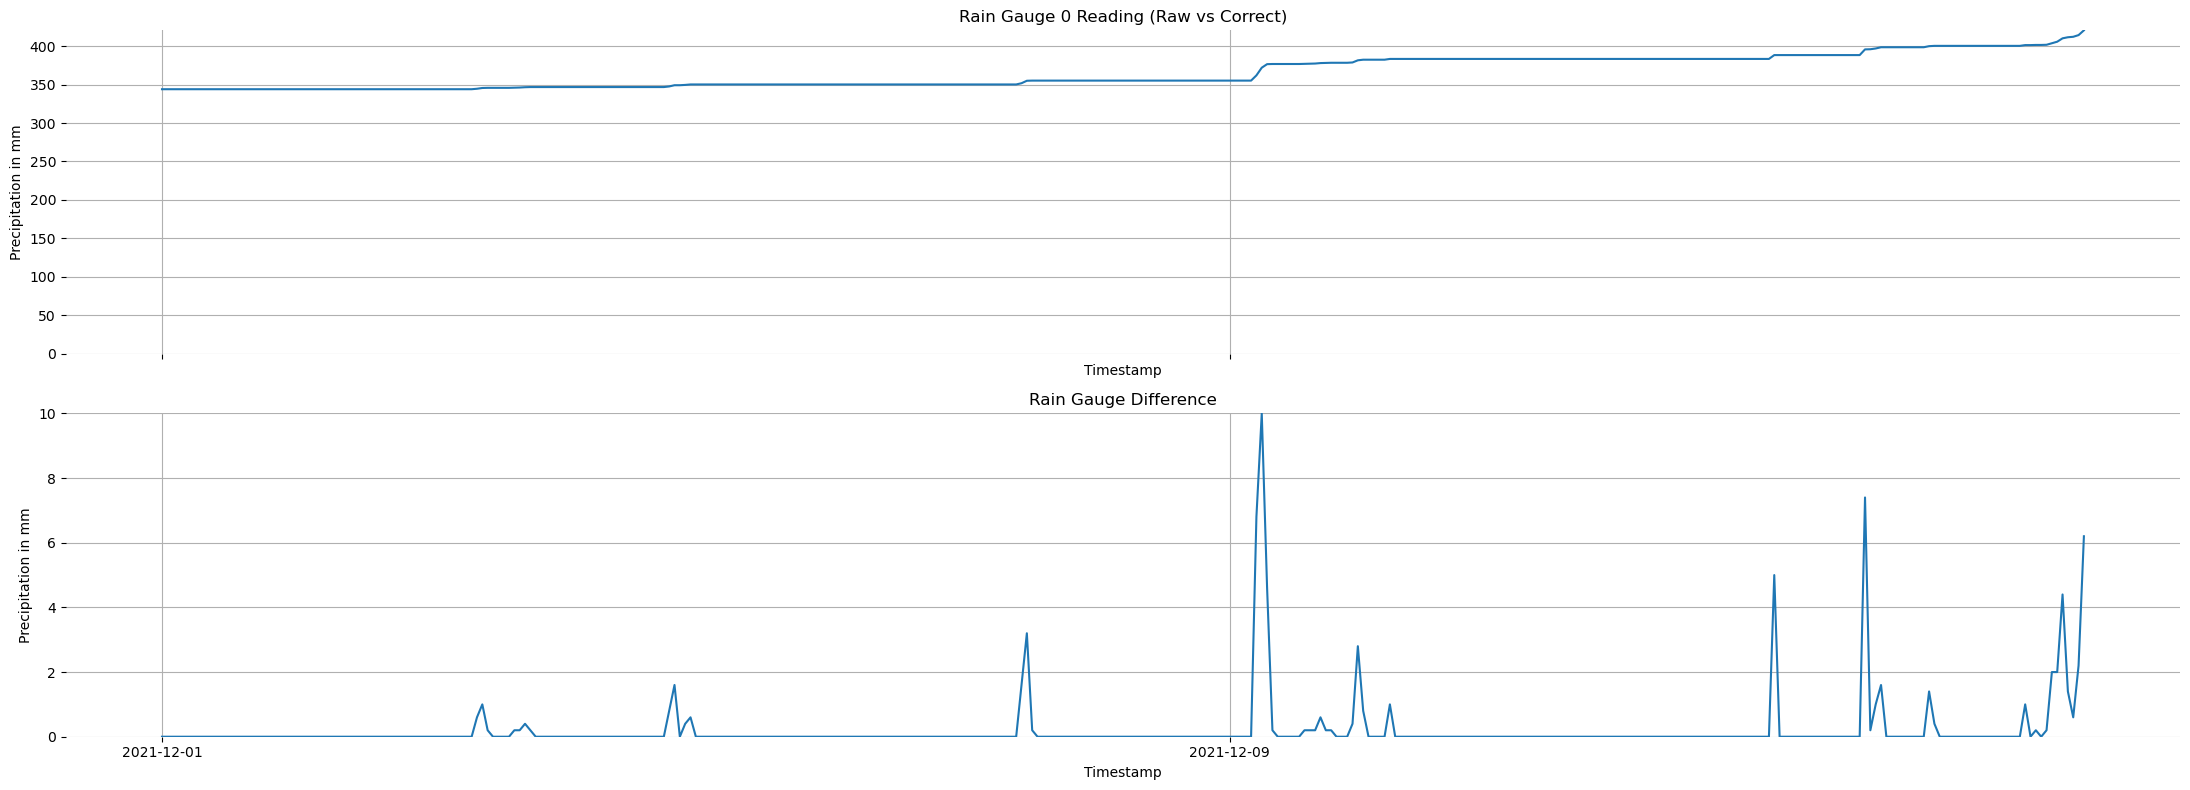

In [16]:
fig, ax = plt.subplots(2,1, figsize=(22,8), sharex=True)

ax[0].plot(main_df['Timestamp'], main_df['Rain Gauge 0'])
ax[0].set_title('Rain Gauge 0 Reading (Raw vs Correct)')
ax[0].set_ylim(0, main_df["Rain Gauge 0"].max())

raw_rg_arry = main_df['Rain Gauge 0'].to_numpy()
raw_rg_max_index = argrelextrema(raw_rg_arry, np.greater , order = 10)[0]
ax[0].scatter(main_df['Timestamp'][raw_rg_max_index], raw_rg_arry[raw_rg_max_index], color='r')

for index in raw_rg_max_index:
    timestamp = str(main_df['Timestamp'][index])
    ax[0].annotate("{}\n{}\n{:.2f}".format(timestamp.split()[0],timestamp.split()[1],raw_rg_arry[index]),
    (main_df['Timestamp'][index],raw_rg_arry[index] + 0.05),
    va='bottom',ha='center',fontsize='x-small')

ax[1].plot(main_df['Timestamp'], main_df['RG0_Diff'])
ax[1].set_title('Rain Gauge Difference')
ax[1].set_ylim(0, main_df["RG0_Diff"].max())

rg_diff_arry = main_df['RG0_Diff'].to_numpy()
rg_diff_max_index = argrelextrema(raw_rg_arry, np.greater , order = 10)[0]
ax[1].scatter(main_df['Timestamp'][rg_diff_max_index], rg_diff_arry[rg_diff_max_index], color='r')

for index in rg_diff_max_index:
    timestamp = str(main_df['Timestamp'][index])
    ax[1].annotate("{}\n{}\n{:.2f}".format(timestamp.split()[0],timestamp.split()[1],rg_diff_arry[index]),
    (main_df['Timestamp'][index],rg_diff_arry[index] + 0.05),
    va='bottom',ha='center',fontsize='x-small')

label = np.arange(0,len(main_df['Timestamp']),1) % 200 == 0
for x in ax:
    x.set_xticks(main_df["Timestamp"].loc[label])
    x.set_xlabel("Timestamp")
    x.set_ylabel("Precipitation in mm")
    x.grid(visible=True)

    x.spines['top'].set_visible(False)
    x.spines['right'].set_visible(False)
    x.spines['bottom'].set_visible(False)
    x.spines['left'].set_visible(False)

fig.tight_layout()

rg_0_fig = fig
plt.show()


Shown below is the ***Rain Gauge 1*** progression for the month

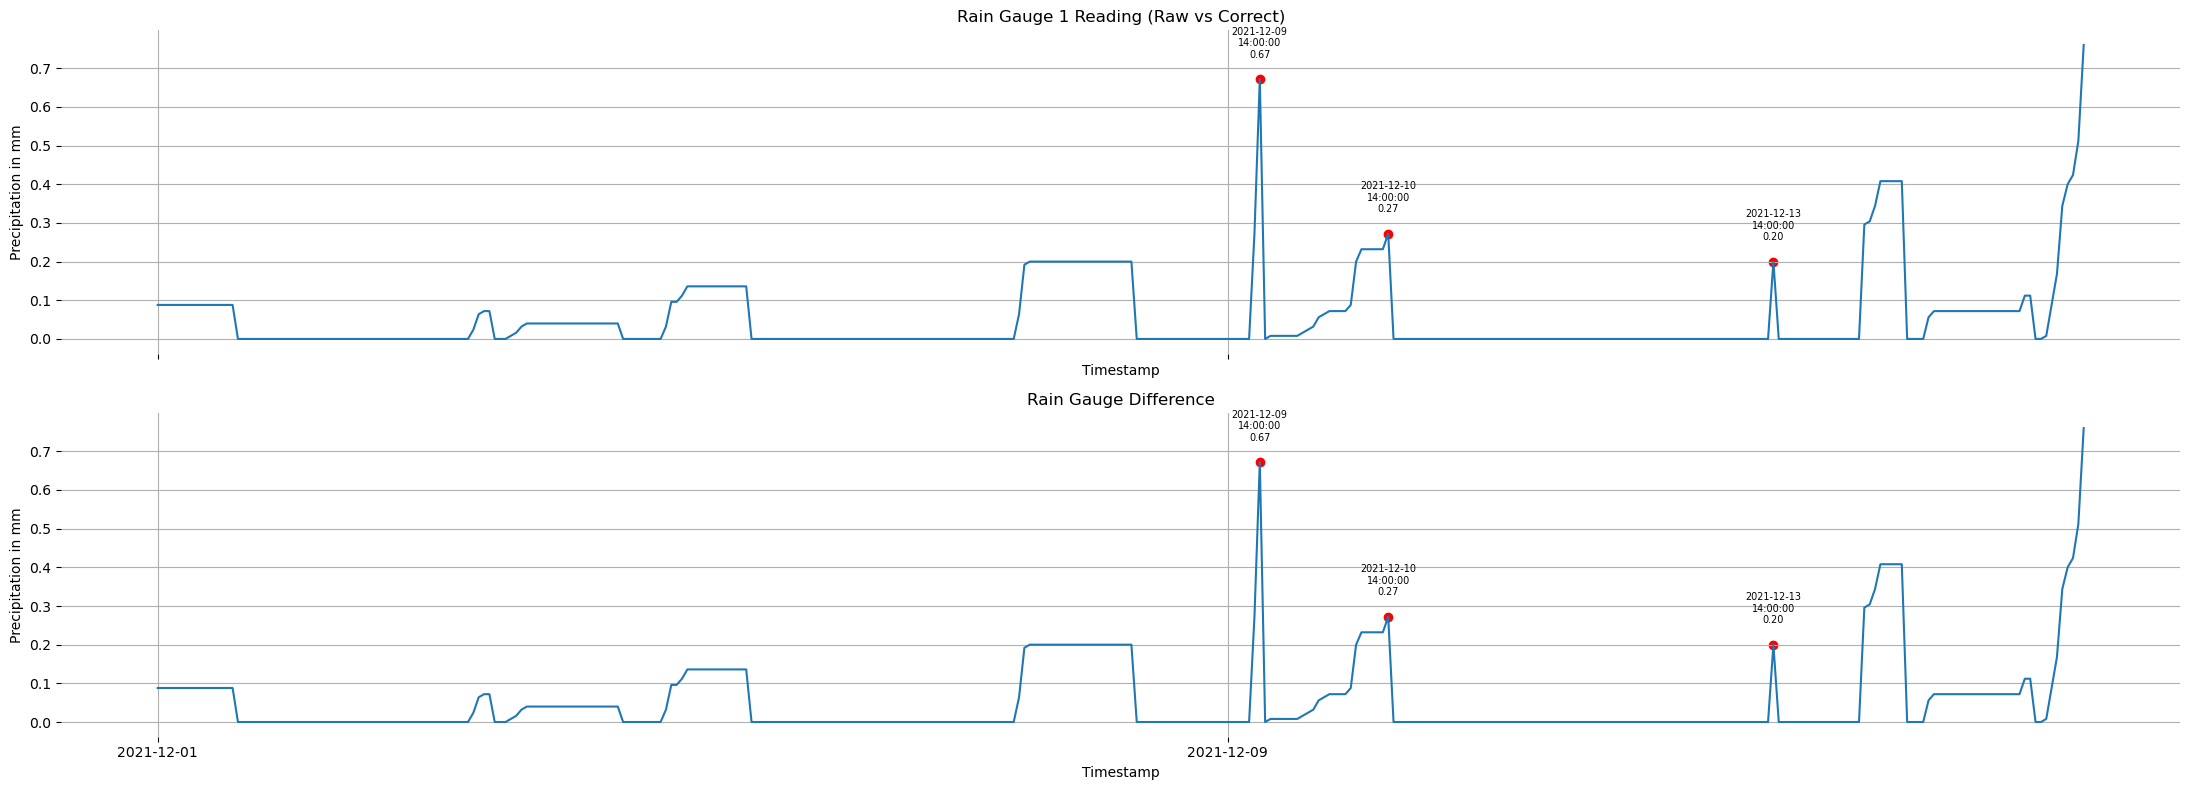

In [17]:
fig, ax = plt.subplots(2,1, figsize=(22,8), sharex=True)

ax[0].plot(main_df['Timestamp'], main_df['Rain Gauge 1'])
ax[0].set_title('Rain Gauge 1 Reading (Raw vs Correct)')

raw_rg_arry = main_df['Rain Gauge 1'].to_numpy()
raw_rg_max_index = argrelextrema(raw_rg_arry, np.greater , order = 10)[0]
ax[0].scatter(main_df['Timestamp'][raw_rg_max_index], raw_rg_arry[raw_rg_max_index], color='r')

for index in raw_rg_max_index:
    timestamp = str(main_df['Timestamp'][index])
    ax[0].annotate("{}\n{}\n{:.2f}".format(timestamp.split()[0],timestamp.split()[1],raw_rg_arry[index]),
    (main_df['Timestamp'][index],raw_rg_arry[index] + 0.05),
    va='bottom',ha='center',fontsize='x-small')

ax[1].plot(main_df['Timestamp'], main_df['RG1_Diff'])
ax[1].set_title('Rain Gauge Difference')

rg_diff_arry = main_df['RG1_Diff'].to_numpy()
rg_diff_max_index = argrelextrema(raw_rg_arry, np.greater , order = 10)[0]
ax[1].scatter(main_df['Timestamp'][rg_diff_max_index], rg_diff_arry[rg_diff_max_index], color='r')

for index in rg_diff_max_index:
    timestamp = str(main_df['Timestamp'][index])
    ax[1].annotate("{}\n{}\n{:.2f}".format(timestamp.split()[0],timestamp.split()[1],rg_diff_arry[index]),
    (main_df['Timestamp'][index],rg_diff_arry[index] + 0.05),
    va='bottom',ha='center',fontsize='x-small')

label = np.arange(0,len(main_df['Timestamp']),1) % 200 == 0
for x in ax:
    x.set_xticks(main_df["Timestamp"].loc[label])
    x.set_xlabel("Timestamp")
    x.set_ylabel("Precipitation in mm")
    x.grid(visible=True)

    x.spines['top'].set_visible(False)
    x.spines['right'].set_visible(False)
    x.spines['bottom'].set_visible(False)
    x.spines['left'].set_visible(False)

fig.tight_layout()

rg_1_fig = fig
plt.show()

In [18]:
time_frmt = '%Y/%m/%d %H:00:00'
main_df['Timestamp'] = main_df['Timestamp'].apply(lambda x: x.strftime(time_frmt))

In [19]:
main_df['Corrected Water Level'] = corrected_main_df['Water Level']

start_str = start_date.strftime("%Y%d%m")
end_str = end_date.strftime("%Y%d%m")

filename = f"{start_str}_{end_str} Report"
parent_directory = "Cleaned_Tagoloan/"

directory = os.path.join(parent_directory,filename)
print("Creating directory {}".format(directory))
try:
    os.mkdir(directory)
except:
    print("Appending to Existing Directory")

with pd.ExcelWriter(os.path.join(directory,f"{filename}.xlsx")) as writer:
    main_df.to_excel(writer, sheet_name=f"{filename}")

water_fig.savefig(os.path.join(directory,f"Water Level {filename}.png"),transparent=False,dpi=600)
rg_0_fig.savefig(os.path.join(directory,f"Rain Gauge 0 {filename}.png"),transparent=False,dpi=600)
rg_1_fig.savefig(os.path.join(directory,f"Rain Gauge 1 {filename}.png"),transparent=False,dpi=600)

missing_rg_0.to_csv(os.path.join(directory,f"Missing RG0 {filename}.csv"))
missing_rg_1.to_csv(os.path.join(directory,f"Missing RG1 {filename}.csv"))
missing_water.to_csv(os.path.join(directory,f"Missing Water {filename}.csv"))

print("Excel Sheet and Figures are successfully saved")

Creating directory Cleaned_Tagoloan/20210112_20211612 Report
Excel Sheet and Figures are successfully saved


: 